In [375]:
import pandas as pd #Pandas is a data analysis tool in python that allows you to read files into a table.

In [376]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [377]:
White_wine = pd.read_csv("wineQualityWhites.csv")
Red_wine = pd.read_csv("wineQualityReds.csv")

### Introduction

<span style="font-family:Times; font-size:1em;">The concept to be learned here is the prediction of the type of Wine Based on the attributes that we have for two types of wines. The data is from Udacity, but can also be traced back to UCI machine learning repository. We are combining two data sets one which has white wines and the other which has red wines</span>

In [378]:
#Check if the columns match in both the tables.
list(White_wine.columns) == list(Red_wine.columns)

True

In [379]:
White_wine['Class'] = 0#For White'
Red_wine['Class'] = 1# For Red'
Master = pd.concat([White_wine,Red_wine])

In [380]:
Master.head()

,Unnamed: 0,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Class
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


In [381]:
Master = Master.drop(columns = ['Unnamed: 0'])# Drop the first column as it doesnot seem very useful.

<span style="font-family:Times; font-size:1em;">
Now before we even start the analysis we need to seperate the machine learning process we need seperate a test and train set, this is important so that we have an indepednant table to test our model on once we complete building it. </span>

In [382]:
len(Master)

6497

<span style="font-family:Times; font-size:1em;">
We have a total of 6497 or 6500 instances, so we will use a 75%-25% split as that will give enough instances to train on and test it out. But before we seperate the table into two parts we should also shuffle the order of the instances so we get a well represented training set.
</span>

In [383]:
Master = Master.sample(frac = 1, random_state =77) #Shuffles the order
Master = Master.reset_index(drop = True)#Remove's the shuffled index indicators

In [384]:
Train,Test = Master.iloc[0:int(0.75*len(Master)),:],Master.iloc[int(0.75*len(Master)):,:]

<BarContainer object of 2 artists>

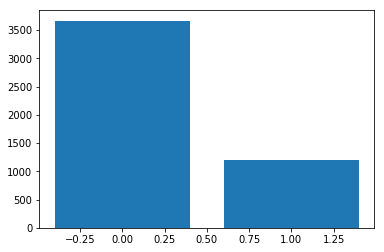

In [385]:
value_object_train = Train['Class'].value_counts()
plt.bar(value_object_train.index,value_object_train.values)

<span style="font-family:Times; font-size:1em;">
We see that there are more white wine examples then red wine examples, so already we can expect this to be unevan class classification. Another thing I would like to mention is that there are many studies that go through alot of feature engineering and preprocessing which is a good thing, but for our example I would like to use a very lazy appraoch. We are going to design a factorial experiment with many classifiers and generate a long list of results. But before lets check if our data is of quality, if it isn't then this approach will not be as effective.

In [386]:
missing_object = []

for i in Train.columns:
    missing_object.append([str(i),Train[i].isnull().sum()])

In [387]:
missing_object

[['fixed.acidity', 0],
 ['volatile.acidity', 0],
 ['citric.acid', 0],
 ['residual.sugar', 0],
 ['chlorides', 0],
 ['free.sulfur.dioxide', 0],
 ['total.sulfur.dioxide', 0],
 ['density', 0],
 ['pH', 0],
 ['sulphates', 0],
 ['alcohol', 0],
 ['quality', 0],
 ['Class', 0]]

<span style="font-family:Times; font-size:1em;">
So our data is of pretty high quality. This means we can use the experimental design to extract infromation from our classifeir. As a buffer, we will take out 10% of the training set to act as a validation dataset. This is so that we are a 100% sure our experimental design produces the best model. 

In [388]:
Train = Train.sample(frac = 1, random_state = 78) #Randomize the order again
Train = Train.reset_index(drop = True)
Xtrain = Train.iloc[0:int(0.9*len(Train)),:]
XValid = Train.iloc[int(0.9*len(Train)):,:]                          

<span style="font-family:Times; font-size:1em;">
    
### Our Design

- Create a factorial setup with factors that might influence the result of you outcome.
- Record the scores and perform ANOVA and get the top 3 algorithms from the experiment.
- Test the algorithms on the validaition set and confirm internally that they are the best.
- If the assumptions arent met, tweek the experimental design.
- Choose the best of the three and use it for test.

<span style="font-family:Times; font-size:1em;">
    
It is now important to create a baseline accuracy for the model, we will use Zero R for this. The metrics we will use for this experimetn are F1 score and Accuracy.

In [389]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [390]:
Baseline = DummyClassifier().fit(Xtrain.iloc[:,0:-1],Xtrain.iloc[:,-1])
Baseline_predict = Baseline.predict(Xtrain.iloc[:,0:-1])

In [391]:
print(accuracy_score(Xtrain.iloc[:,-1],Baseline_predict)) #Baseline Accuracy
print(f1_score(Xtrain.iloc[:,-1],Baseline_predict,)) #Baseline F1

0.6370894160583942
0.2651270207852194


In [392]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF

In [452]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score as CRVS

In [394]:
import time

In [395]:
X,y = Xtrain.iloc[:,0:-1],Xtrain.iloc[:,-1]#seperating X & Y

In [396]:
def experiment(X,y,T):
    total_rounds = T
    C = 0
    output = []
    for transform in [(None,None),(MinMaxScaler,"MinmaxScaler"),(QuantileTransformer,'QuantileTransformer')]:
        if transform[0] != None:
            X_val = transform[0]().fit_transform(X,y)
        else:
            X_val = X
        for metric in [(f_classif,'f_classif'),(chi2,'chi2')]:
            for kbest in [1,2,3,4,5,6,7,8,9,10,11,12]:
                X_new = SelectKBest(metric[0],k = kbest).fit_transform(X_val,y)
                for classifier in [LR(solver = 'lbfgs', max_iter=1000),DTC(),SVC(gamma = 'auto'),KNN(),NB(),GBC(),RF(n_estimators=10)]:
                    for method in ['accuracy','f1']:
                        X_new = np.asarray(X_new)
                        scores = CRVS(classifier,X_new,y,scoring = method,cv = 3)
                        stats = [str(transform[1]),str(metric[1]),str(kbest),str(type(classifier).__name__),str(method)]
                        for sk in scores:
                            output.append(stats + [sk])
                            if C in total_rounds:
                                print (C, end = "\t")
                            C += 1
    return output
                    
            

In [397]:
Total_Rounds =[i for i in range(1,3*2*12*7*2*3+2,300)]
start = time.time()
records  = experiment(X,y,Total_Rounds)
end = time.time()

1	301	601	

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


901	

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


1201	1501	1801	2101	2401	2701	3001	

In [398]:
(end - start)

149.2545349597931

In [399]:
Observations = pd.DataFrame(records,columns = ['TRANS','MKBEST','KNUM','CLX','MET','SK'])

In [400]:
F1_scores = Observations[Observations['MET'] == 'f1'].drop(columns = ['MET'])
Accuracy_scores = Observations[Observations['MET'] == 'accuracy'].drop(columns = ['MET'])

<span style="font-family:Times; font-size:1em;">
Now that we collected the data from our experiment we can now analyse it using ANOVA. It is much easier to send this to SAS and do the analysis there but for convinencen we will try to do the same anamlysis here using.

In [401]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [402]:
Analysis_1 = ols('SK ~ TRANS + MKBEST + KNUM + CLX',data=F1_scores).fit()

In [403]:
sm.stats.anova_lm(Analysis_1, typ=2)

,sum_sq,df,F,PR(>F)
TRANS,0.726794,2.0,434.229228,2.488786e-149
MKBEST,0.032036,1.0,38.280643,7.899359e-10
KNUM,1.916041,11.0,208.137154,9.995403e-292
CLX,0.372742,6.0,74.232650,3.519261e-81
Residual,1.247786,1491.0,NaN,NaN


In [404]:
def resCheck(check, model): #Quick function to output diagnostic plots
    if check == 'rvp':
        pred = model.fittedvalues
        res = model.resid
        a = plt.scatter(pred,res)
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        return a
    elif check == 'qq':
        sm.qqplot(model.resid)
        

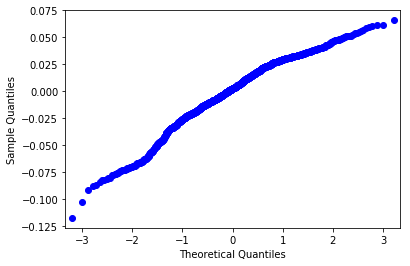

In [405]:
resCheck('qq',Analysis_1)

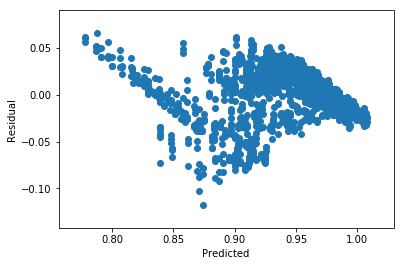

In [406]:
resCheck('rvp',Analysis_1)

<span style="font-family:Times; font-size:1em;">
 Based on the diagnostic plot's we have a good foundation to apply statistical applications to as they fully satisfy our assumptions.

<span style="font-family:Times; font-size:1em;">
We are looking at the analysis of the F1 score. We could have used a full factorial anova to analyse the combinations but I think that would be overkill, keeping things simple and using a basic added model should provide enough analysis to take a foreward step with this research. Looking at the F values we can see that some values potentially provide more explanation on the variance of the scores compared to other values. Looking at the F Values it can already be seen that the largest variation in F1 scores is due to the type of transformation that has been applied to it. Lets have a look at how this works out.

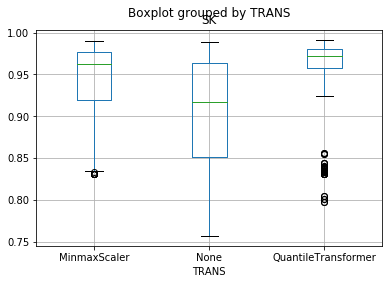

In [407]:
F1_scores.boxplot(column='SK', by='TRANS')

<span style="font-family:Times; font-size:1em;">
Looking at the three types of transformations we used which are None, MinMax Scaler and Quantile Transformation, we see visually that a Quantile trasnformation has a tight scores space and look's like is providing consistently high scores. But at the same time it seem's to have the most outliers. Based on this we can say that the competition really comes down to MinMax vs Quantile transformations. We could skip this and assume Quantile trasnformation's are better based on the visualization, but just to be sure we will apply statsitical tests on the two types. We could compare them using a T-Test, but lets use some of the other tool's in our design arsenal and test these two treatments with the contrasts.

In [408]:
stats.ttest_ind(F1_scores[F1_scores['TRANS'] == 'MinmaxScaler']['SK'],F1_scores[F1_scores['TRANS'] == 'QuantileTransformer']['SK'])

Ttest_indResult(statistic=-4.925466032901253, pvalue=9.83364633030043e-07)

<span style="font-family:Times; font-size:1em;">
Though the t-test is two sided by default, we can still use it to infer about the populations. The t statistic is negative which means Quantile transformations are leading to higher scores than Min Max scaler trasnformations. So we can be assured that Quantile transformations are more effective. After this we will look at the number of attributes selected and the resuling accuracy scores.

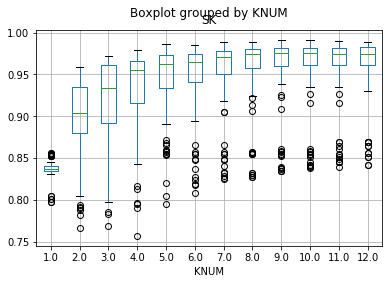

In [418]:
Temp_F1_scores = F1_scores
Temp_F1_scores.boxplot(column='SK', by='KNUM')

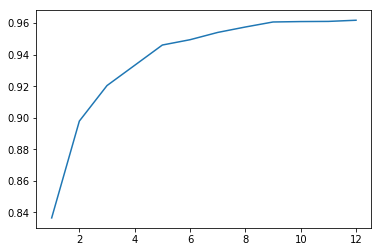

In [419]:
Temp_F1_scores = F1_scores
Temp_F1_scores['KNUM'] = F1_scores['KNUM'].astype('float')
plt.plot(Temp_F1_scores.groupby(['KNUM'])['SK'].mean())

<span style="font-family:Times; font-size:1em;">
Based on the plot's shown above it can be seen that there is no harm in including all the attributes in our example. Of course we are calculating the improvement of the F1 score, but generally a decrease in error is looked at rather than the increase in accruacy. But we can use these method's as well.Next we will look at what classifier contributed in the highest scores.

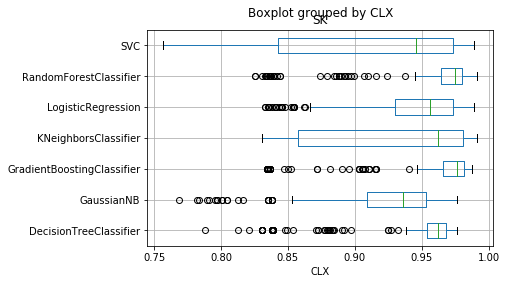

In [429]:
F1_scores.boxplot(column='SK', by='CLX',vert=False)

<span style="font-family:Times; font-size:1em;">
We see that the two most consistent classifiers were Random forrest and Gradient Boosting, so we will do a t-test on these two. But we will aslo look at the maximum scores obtained by each learning scheme. As we don't want to eliminate exceptiona;l performances.

In [430]:
F1_scores.groupby(['CLX'])['SK'].max()

CLX
DecisionTreeClassifier        0.976422
GaussianNB                    0.976157
GradientBoostingClassifier    0.987377
KNeighborsClassifier          0.991643
LogisticRegression            0.988889
RandomForestClassifier        0.991643
SVC                           0.988889
Name: SK, dtype: float64

<span style="font-family:Times; font-size:1em;">
But as a reasearher we have to trust the data, no matter how exceptional SVC and KNN performed they have a large variance of scores. Thus it would be better if we relied on either random forrest or gradient boosting.

In [431]:
stats.ttest_ind(F1_scores[F1_scores['CLX'] == 'GradientBoostingClassifier']['SK'],F1_scores[F1_scores['CLX'] == 'RandomForestClassifier']['SK'])

Ttest_indResult(statistic=0.3671372051376721, pvalue=0.7136972878113821)

<span style="font-family:Times; font-size:1em;">
We see that the results are inconclusive, so we might consider trying them both in the validations section to see which is better. Lastly we look at what selection method was better in determining attribute selection, but in all honesty this can be skipped because we already concluded that there wasn't any problem using all the attributes. But this is a lazy approach, as some of the attributes like quality would be a redundant test for any algorithm. But for convinience we are going to use all attributes. Lastly we will look at two more ANOVAS.

In [433]:
Analysis_2 = ols('SK ~ TRANS + MKBEST + KNUM + CLX',data=Accuracy_scores).fit()
Analysis_3 = ols('SK ~ TRANS * MKBEST * KNUM * CLX',data=Accuracy_scores).fit()

In [434]:
sm.stats.anova_lm(Analysis_2, typ=2)

,sum_sq,df,F,PR(>F)
TRANS,0.154769,2.0,427.329842,1.972528e-147
MKBEST,0.007601,1.0,41.972417,1.254194e-10
KNUM,0.422846,11.0,212.275250,1.379858e-295
CLX,0.082760,6.0,76.169208,4.232219e-83
Residual,0.270003,1491.0,NaN,NaN


<span style="font-family:Times; font-size:1em;">

Based on this we see that we see that looking at accuracy as metric will most likely produce similar results as the previous test. So we can assume tesing only F1 scores should be sufficient to generalise.

In [435]:
sm.stats.anova_lm(Analysis_3, typ=2)

,sum_sq,df,F,PR(>F)
TRANS,0.154769,2.0,5972.799071,0.000000e+00
MKBEST,0.007601,1.0,586.649438,1.649471e-102
KNUM,0.422846,11.0,2966.976078,0.000000e+00
CLX,0.082760,6.0,1064.618785,0.000000e+00
TRANS:MKBEST,0.007196,2.0,277.704545,8.540856e-97
TRANS:KNUM,0.032073,22.0,112.523042,3.974663e-253
MKBEST:KNUM,0.014588,11.0,102.362030,1.093075e-155
TRANS:CLX,0.120890,12.0,777.559784,0.000000e+00
MKBEST:CLX,0.001580,6.0,20.320010,1.565821e-22
KNUM:CLX,0.020574,66.0,24.059860,4.255054e-163


<span style="font-family:Times; font-size:1em;">
Lastly we look at the interaction for all the factors in our experiment. As the interaction terms are significant it only means that certain combinations work better than others. Based on the test's we did on each individual factore above and selecting the best ones should be sufficient to derive a good model with. 

<span style="font-family:Times; font-size:1em;">
    
### ML Architecture

- Quantile trasnform the X matrix
- Use all attributes
- Use either Random Forrest or Gradient Boosted Trees

In [460]:
#Data Pred
transformer = MinMaxScaler().fit(X,y)
X_2 = transformer.transform(X)
VX_2 = transformer.transform(XValid.iloc[:,:-1])
Validation_y = XValid.iloc[:,-1]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [461]:
RandomForrest = RF(n_estimators = 10).fit(X_2,y)
BoostedT = GBC().fit(X_2,y)

In [462]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [465]:
predict1 = RandomForrest.predict(VX_2)
predict2 = BoostedT.predict(VX_2)
print ("AccuracyRF", accuracy_score(Validation_y,predict1))
print ("BoostedRF",f1_score(Validation_y,predict1))

print ("AccuracyGB", accuracy_score(Validation_y,predict2))
print ("BoostedGB",f1_score(Validation_y,predict2))

AccuracyRF 0.9836065573770492
BoostedRF 0.968
AccuracyGB 0.9959016393442623
BoostedGB 0.9921259842519685



We can conclude that Gradient Boosting is the algorithm of choice here. Now we can test it on the final data set. Again at this point you could fine tune the model and reiterate the entrie process untill you have a very fine tuned model. But the main risk is over fitting, so with such scores its better to let the model be as it is.

In [464]:
Final_set = transformer.transform(Test.iloc[:,:-1])
Final_Y = Test.iloc[:,-1]

In [466]:
predict3 = BoostedT.predict(Final_set)

In [470]:
print ("Final Accuracy", accuracy_score(Final_Y,predict3))
print ("Final F1",f1_score(Final_Y,predict3))

Final Accuracy 0.9926153846153846
Final F1 0.9846547314578005
